In [14]:
import requests
import pandas as pd
import time

def reconstruct_abstract(inverted_index):
    """OpenAlex의 역색인(Inverted Index)을 사람이 읽을 수 있는 텍스트로 복원"""
    if not inverted_index:
        return ""
    word_index = []
    for word, positions in inverted_index.items():
        for pos in positions:
            word_index.append((pos, word))
    # 위치 순서대로 단어 정렬 및 합치기
    return " ".join([word for _, word in sorted(word_index)])

# 1. 검색 설정
# ALD와 Precursor가 제목이나 초록에 들어간 논문 검색
base_url = "https://api.openalex.org/works"
query = "Atomic Layer Deposition Precursor"

params = {
    "search": query,
    "filter": "from_publication_date:2020-01-01", # 2020년 이후 논문만
    "per_page": 200, # 페이지당 개수 (최대 200)
    "select": "id,title,publication_year,abstract_inverted_index,concepts"
}

print(f"🔍 OpenAlex에서 '{query}' 검색 시작 (2020년~)...")

all_data = []
# 5페이지 정도만 긁어봅시다 (약 1,000개 목표)
for page in range(1, 6):
    params["page"] = page
    try:
        response = requests.get(base_url, params=params)
        if response.status_code != 200:
            print(f"페이지 {page} 로드 실패: {response.status_code}")
            break

        results = response.json().get('results', [])
        if not results:
            print("더 이상 데이터가 없습니다.")
            break

        print(f"페이지 {page}: {len(results)}개 수집 중...")

        for item in results:
            abstract_text = reconstruct_abstract(item.get('abstract_inverted_index'))

            # 초록이 너무 짧으면(데이터 누락) 제외
            if len(abstract_text) < 50:
                continue

            all_data.append({
                'year': item['publication_year'],
                'title': item['title'],
                'abstract': abstract_text
            })

        time.sleep(0.5) # 서버 부하 방지

    except Exception as e:
        print(f"에러 발생: {e}")
        break

# 저장
df = pd.DataFrame(all_data)
file_name = 'ald_openalex_data.csv'
df.to_csv(file_name, index=False, encoding='utf-8-sig')

print("------------------------------------------------")
print(f"🎉 수집 대성공! '{file_name}' 파일 생성 완료.")
print(f"총 {len(df)}개의 양질의 논문 데이터를 확보했습니다.")
print("------------------------------------------------")
print(df[['year', 'title']].head())

🔍 OpenAlex에서 'Atomic Layer Deposition Precursor' 검색 시작 (2020년~)...
페이지 1: 200개 수집 중...
페이지 2: 200개 수집 중...
페이지 3: 200개 수집 중...
페이지 4: 200개 수집 중...
페이지 5: 200개 수집 중...
------------------------------------------------
🎉 수집 대성공! 'ald_openalex_data.csv' 파일 생성 완료.
총 738개의 양질의 논문 데이터를 확보했습니다.
------------------------------------------------
   year                                              title
0  2020  Growth of thin film ferroelectric PZT, PHT, an...
1  2021  Rational Development of Guanidinate and Amidin...
2  2024  Toward fast and accurate machine learning inte...
3  2021  Role of Precursor Choice on Area-Selective Ato...
4  2020  Effects of Al Precursors on Deposition Selecti...


In [15]:
import requests
import pandas as pd
import time

# 1. 기존 데이터 로드 (2020~ 현재)
try:
    df_recent = pd.read_csv('ald_openalex_data.csv')
    print(f"기존 최신 데이터 로드 완료: {len(df_recent)}건")
except FileNotFoundError:
    print("기존 파일이 없습니다. 전체를 새로 수집합니다.")
    df_recent = pd.DataFrame()

# 2. 과거 데이터 수집 함수 (OpenAlex)
def fetch_ald_data(start_year, end_year):
    base_url = "https://api.openalex.org/works"
    query = "Atomic Layer Deposition Precursor"
    params = {
        "search": query,
        "filter": f"from_publication_date:{start_year}-01-01,to_publication_date:{end_year}-12-31",
        "per_page": 200,
        "select": "id,title,publication_year,abstract_inverted_index"
    }

    data_list = []
    print(f"🔍 {start_year}~{end_year} 데이터 수집 시작...")

    for page in range(1, 6): # 5페이지(약 1000개)만 수집
        params["page"] = page
        try:
            response = requests.get(base_url, params=params)
            results = response.json().get('results', [])
            if not results: break

            for item in results:
                # 역색인 복원 로직
                inv_idx = item.get('abstract_inverted_index')
                if not inv_idx: continue
                word_index = []
                for word, positions in inv_idx.items():
                    for pos in positions:
                        word_index.append((pos, word))
                abstract = " ".join([w for _, w in sorted(word_index)])

                if len(abstract) > 50:
                    data_list.append({
                        'year': item['publication_year'],
                        'title': item['title'],
                        'abstract': abstract
                    })
            time.sleep(0.5)
        except: break

    return pd.DataFrame(data_list)

# 3. 2015~2019년 데이터 수집 실행
df_past = fetch_ald_data(2015, 2019)
print(f"과거 데이터 수집 완료: {len(df_past)}건")

# 4. 데이터 병합
df_all = pd.concat([df_recent, df_past], ignore_index=True)
print(f"✅ 전체 데이터 병합 완료: 총 {len(df_all)}건")

기존 최신 데이터 로드 완료: 738건
🔍 2015~2019 데이터 수집 시작...
과거 데이터 수집 완료: 715건
✅ 전체 데이터 병합 완료: 총 1453건


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['atomic', 'crystalline', 'review'] not in stop_words.
  warnings.warn(
/tmp/ipython-input-3306241822.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_viz, x='Change', y='Keyword', palette=colors)


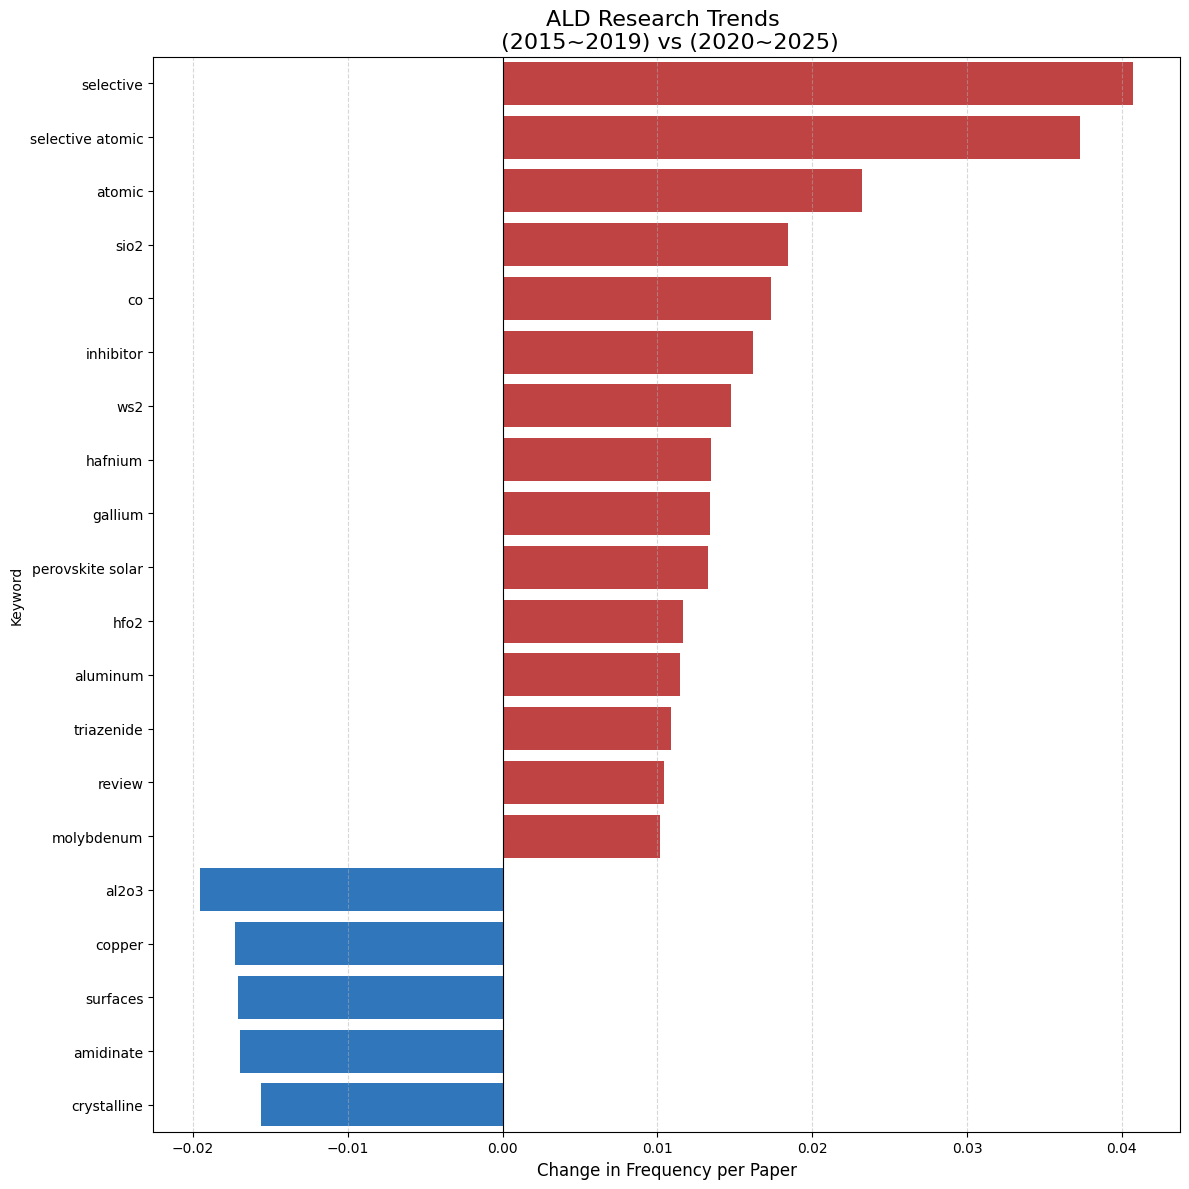

🔥 [정제된 급상승 키워드 Top 10]
               Keyword    Change
882          selective  0.040741
883   selective atomic  0.037287
93              atomic  0.023227
921               sio2  0.018447
231                 co  0.017310
541          inhibitor  0.016173
1114               ws2  0.014731
482            hafnium  0.013463
449            gallium  0.013419
760   perovskite solar  0.013289


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import re

# 1. 데이터 준비 (기존 데이터프레임 df_all 사용)
# df_all = pd.read_csv('ald_openalex_data.csv') # 파일 로드 필요시 주석 해제

# 2. 제목 전처리
def clean_title(text):
    if pd.isna(text): return ""
    text = str(text).lower()
    text = re.sub(r'<.*?>', '', text) # HTML 태그 제거
    text = re.sub(r'sub|sup', '', text)
    text = re.sub(r'[^\w\s]', ' ', text) # 특수문자 제거
    return text

df_all['clean_title'] = df_all['title'].apply(clean_title)

# 3. 불용어(Stopwords) 업데이트 (and, area 추가됨)
stopwords_final = [
    # [추가된 단어]
    'and', 'area',

    # [기존 노이즈 제거 리스트]
    'the', 'a', 'an', 'of', 'in', 'on', 'at', 'to', 'for', 'by', 'with', 'from', 'as', 'via',
    'grown', 'growth', 'growing', 'deposit', 'deposited', 'deposition', 'review'
    'reaction', 'reactions', 'mechanism', 'process', 'processes',
    'small', 'large', 'new', 'novel', 'facile', 'efficient', 'direct',
    'role', 'effect', 'effects', 'influence', 'impact', 'study', 'studies',
    'assisted', 'enhanced', 'promote', 'promoted', ' atomic', 'atomic ', ' review', 'review '
    'crystalline', 'crystallinity', 'amorphous', 'phase',
    'oxidation', 'oxidized', 'reduction',
    'doped', 'doping', 'codoped',
    'framework', 'structure', 'structures', 'layered',
    'properties', 'performance', 'characteristic', 'characteristics', 'characterization',
    'application', 'applications', 'device', 'devices',
    'synthesis', 'synthesized', 'prepared', 'preparation',
    'using', 'used', 'use', 'based',
    'high', 'low', 'temperature', 'thermal', 'plasma', 'gas'
    'atomic', 'layer', 'ald', 'thin', 'film', 'films', 'precursor', 'precursors',
    'metal', 'oxide', 'nitride', 'sulfide', 'gas'
    'showed', 'reported', 'demonstrated', 'observed',
    'we', 'our', 'their', 'its', 'authors',
    'b', 'c', 'd', 'x', 'y', 'z'
]

# 4. 벡터화 설정
vectorizer = CountVectorizer(
    stop_words=stopwords_final,
    ngram_range=(1, 2),
    min_df=3,
    token_pattern=r'(?u)\b\w\w+\b'
)

# 5. 시기별 데이터 분리
period_past = (2015, 2019)
period_recent = (2020, 2025)

df_past = df_all[(df_all['year'] >= period_past[0]) & (df_all['year'] <= period_past[1])]
df_recent = df_all[(df_all['year'] >= period_recent[0]) & (df_all['year'] <= period_recent[1])]

# 6. 빈도 분석 실행
vectorizer.fit(df_all['clean_title'])
vocab = vectorizer.get_feature_names_out()

def get_freq(df_subset, vectorizer):
    if len(df_subset) == 0: return None
    X = vectorizer.transform(df_subset['clean_title'])
    counts = np.asarray(X.sum(axis=0)).flatten()
    return counts / len(df_subset)

freq_past = get_freq(df_past, vectorizer)
freq_recent = get_freq(df_recent, vectorizer)

# 7. 결과 시각화
df_trend = pd.DataFrame({
    'Keyword': vocab,
    'Change': freq_recent - freq_past,
    'Recent_Freq': freq_recent,
    'Past_Freq': freq_past
})

top_rising = df_trend.sort_values('Change', ascending=False).head(15)
top_falling = df_trend.sort_values('Change', ascending=True).head(5)
df_viz = pd.concat([top_rising, top_falling])

plt.figure(figsize=(12, 12))
colors = ['#D32F2F' if x > 0 else '#1976D2' for x in df_viz['Change']]

sns.barplot(data=df_viz, x='Change', y='Keyword', palette=colors)
plt.title('ALD Research Trends \n (2015~2019) vs (2020~2025)', fontsize=16)
plt.xlabel('Change in Frequency per Paper', fontsize=12)
plt.axvline(0, color='black', linewidth=0.8)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print("🔥 [정제된 급상승 키워드 Top 10]")
print(top_rising[['Keyword', 'Change']].head(10))